# Imports

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

---

# Carga de datos

In [2]:
features = pd.read_pickle("../../features/auctions_train_ventana_1.pkl")
targets = pd.read_pickle("../../targets/targets_ventana_1_auctions.pkl")
train = features.merge(targets, left_index=True, right_index=True)

---

# Preparación del set de datos para XGBoost

In [3]:
X, y = train.iloc[:,:-1], train.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [11]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.5,
                n_estimators = 100, n_jobs=6, max_depth=7, objective="reg:linear")

In [12]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=6, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [15]:
preds = xg_reg.predict(X_test.iloc[:100])
rmse = np.sqrt(mean_squared_error(y_test.iloc[:100], preds))
print("RMSE: %f" % (rmse))

RMSE: 89107.116607


---

# Pruebas

In [20]:
features_auctions = pd.read_pickle("../../features/auctions_train_ventana_1.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_1.pkl")

In [21]:
features_combinados_imputados = features_auctions.merge(features_clicks, right_index=True, left_index=True, suffixes=('_auctions', '_clicks')).fillna(0)

In [17]:
len(features_combinados_imputados)

9144

In [27]:
#features_auctions = pd.read_pickle("../../features/auctions_train_ventana_3.pkl")
targets = pd.read_pickle("../../targets/targets_ventana_1_auctions.pkl")
train = features_combinados_imputados.merge(targets, left_index=True, right_index=True)

X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)
# make prediction
#preds = bst.predict(dtest)
#Stopping. Best iteration:
#[360]	train-rmse:67651	test-rmse:69665.3a

[0]	train-rmse:112057	test-rmse:113310
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:106220	test-rmse:107639
[2]	train-rmse:100664	test-rmse:102448
[3]	train-rmse:95998.8	test-rmse:98074.7
[4]	train-rmse:91925.2	test-rmse:94382.7
[5]	train-rmse:88440.8	test-rmse:91209.7
[6]	train-rmse:85339	test-rmse:88431.3
[7]	train-rmse:82728.4	test-rmse:86177.8
[8]	train-rmse:80499.4	test-rmse:84284.5
[9]	train-rmse:78494	test-rmse:82702.5
[10]	train-rmse:76818.4	test-rmse:81374.8
[11]	train-rmse:75350.1	test-rmse:80181.9
[12]	train-rmse:74086.8	test-rmse:79207
[13]	train-rmse:72958.6	test-rmse:78540.7
[14]	train-rmse:71949.1	test-rmse:77874.5
[15]	train-rmse:71099.3	test-rmse:77349.9
[16]	train-rmse:70341.1	test-rmse:76963.5
[17]	train-rmse:69703.8	test-rmse:76625.2
[18]	train-rmse:69078.7	test-rmse:76353
[19]	train-rmse:68561.6	test-rmse:76070.3
[20]	train-rmse:68129.1	test-rmse:75840.2

---

# Prueba con 1 modelo y todos los datos

In [88]:
f1 = pd.read_pickle("../../features/auctions_train_ventana_3.pkl")
f2 = pd.read_pickle("../../features/clicks_train_ventana_3.pkl")

In [123]:
magifeatures = f2.dropna().merge(f1, left_index=True, right_index=True)
magifeatures = f1
magitargets = pd.read_pickle("../../targets/targets_ventana_4_auctions.pkl")
magitrain = magifeatures.merge(magitargets, left_index=True, right_index=True)

RMSE: 91594.76587955047


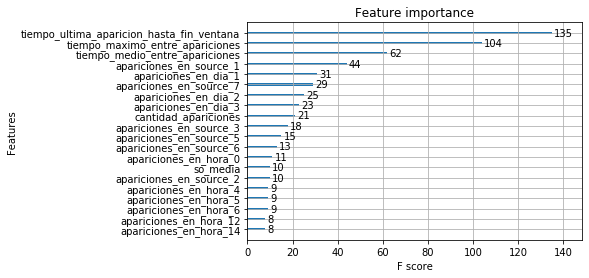

In [125]:
from xgboost import XGBRegressor, plot_importance
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from math import sqrt

X, y = magitrain.iloc[:,:-1], magitrain.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=0)

# fit model on all training data
model = XGBRegressor(n_jobs=6)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
print("RMSE: {}".format(sqrt(rmse)))

plot_importance(model, max_num_features=20)
pyplot.show()

In [81]:
X, y = magitrain.iloc[:,:-1], magitrain.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 1,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.01}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)

[0]	train-rmse:96668	test-rmse:97589
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:95803.1	test-rmse:96752.1
[2]	train-rmse:94947.5	test-rmse:95922.1
[3]	train-rmse:94101.3	test-rmse:95099.8
[4]	train-rmse:93264.1	test-rmse:94284.5
[5]	train-rmse:92435.6	test-rmse:93486.2
[6]	train-rmse:91616.1	test-rmse:92697.2
[7]	train-rmse:90806.1	test-rmse:91911.4
[8]	train-rmse:90004.6	test-rmse:91141.2
[9]	train-rmse:89210.7	test-rmse:90370.2
[10]	train-rmse:88427	test-rmse:89613.2
[11]	train-rmse:87650.5	test-rmse:88858.8
[12]	train-rmse:86884	test-rmse:88111.6
[13]	train-rmse:86124.1	test-rmse:87368.3
[14]	train-rmse:85374.5	test-rmse:86637.4
[15]	train-rmse:84631.2	test-rmse:85913.1
[16]	train-rmse:83898.1	test-rmse:85200.7
[17]	train-rmse:83171.3	test-rmse:84494.5
[18]	train-rmse:82451.7	test-rmse:83792.2
[19]	train-rmse:81740	test-rmse:83095.8
[20]	train-rmse:81036.4	test-rmse:824

In [12]:
features = pd.read_pickle("../../features/auctions_train_ventana_1.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_1.pkl")
features.merge(features_clicks, right_index=True, left_index=True, how="left", suffixes=('_auctions', '_clicks'))
targets = pd.read_pickle("../../targets/targets_ventana_1_auctions.pkl")
train = features.merge(targets, left_index=True, right_index=True)

features = pd.read_pickle("../../features/auctions_train_ventana_2.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_2.pkl")
features.merge(features_clicks, right_index=True, left_index=True,how="left", suffixes=('_auctions', '_clicks'))
targets = pd.read_pickle("../../targets/targets_ventana_2_auctions.pkl")
train = train.append(features.merge(targets, left_index=True, right_index=True))

features = pd.read_pickle("../../features/auctions_train_ventana_3.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_3.pkl")
features.merge(features_clicks, right_index=True, left_index=True,how="left", suffixes=('_auctions', '_clicks'))
targets = pd.read_pickle("../../targets/targets_ventana_3_auctions.pkl")
train = train.append(features.merge(targets, left_index=True, right_index=True))

features = pd.read_pickle("../../features/auctions_train_ventana_4.pkl")
features_clicks = pd.read_pickle("../../features/clicks_train_ventana_4.pkl")
features.merge(features_clicks, right_index=True, left_index=True,how="left", suffixes=('_auctions', '_clicks'))
targets = pd.read_pickle("../../targets/targets_ventana_4_auctions.pkl")
train = train.append(features.merge(targets, left_index=True, right_index=True))

In [13]:
len(train)

1286041

In [6]:
X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

param = {'max_depth':6,
         'eta':0.3,
         'silent':1,
         'objective':'reg:linear',
         'eval_metric' : 'rmse',
         'obj' : 'reg:squarederror',
         'colsample_bytree' : 0.7,
         'min_child_weight' : 0.5,
         'random_state' : 0,
         'reg_alpha' : 0,
         'reg_lambda' : 1,
         'scale_pos_weight' : 1,
         'learning_rate' : 0.1}


num_round = 5000
stopping = 20
bst = xgb.train(param, dtrain, num_round, evals=[(dtrain, "train"), (dtest, "test")], early_stopping_rounds=stopping)
#Stopping. Best iteration:
#[491]	train-rmse:87591.8	test-rmse:88927.6

[0]	train-rmse:148653	test-rmse:148587
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:139480	test-rmse:139442
[2]	train-rmse:131518	test-rmse:131506
[3]	train-rmse:124678	test-rmse:124691
[4]	train-rmse:118979	test-rmse:119009
[5]	train-rmse:114005	test-rmse:114059
[6]	train-rmse:109780	test-rmse:109856
[7]	train-rmse:106277	test-rmse:106376
[8]	train-rmse:103325	test-rmse:103442
[9]	train-rmse:100868	test-rmse:101003
[10]	train-rmse:98804.3	test-rmse:98956.9
[11]	train-rmse:97094.8	test-rmse:97263.8
[12]	train-rmse:95673.1	test-rmse:95857.8
[13]	train-rmse:94506.1	test-rmse:94703.8
[14]	train-rmse:93553.4	test-rmse:93762.4
[15]	train-rmse:92746.7	test-rmse:92965.8
[16]	train-rmse:92086.6	test-rmse:92313.7
[17]	train-rmse:91544.8	test-rmse:91780
[18]	train-rmse:91100.4	test-rmse:91344
[19]	train-rmse:90733.3	test-rmse:90984.2
[20]	train-rmse:90441.6	test-rmse:90700.3
[21]	trai

KeyboardInterrupt: 